### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import itertools
# Used for mathematical functions
import math             
import logging

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
# import pyproj
# import shapely.geometry
# from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import tqdm


import plotly.express as px
from plotly.subplots import make_subplots

# OpenTNSim
import opentnsim

# turn on debug messages if want to see what's going on in detail
# logging.basicConfig(level=logging.DEBUG)
# turn off debug messages, only show info and higher level messages
logging.basicConfig(level=logging.INFO)

### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [2]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [3]:
# Create a dict with all important settings

data_vessel = {
    "env": None,
    "name": 'Vessel M6',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3,
    "use_V_g_profile":False,
    "type": None,
    "B": 9.5,
    "L": 85,
    "H_e": None, 
    "H_f": None, 
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 780.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.064,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1961,
}             



In [4]:
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

### Set vessel properties and sailing conditions ( input value )

In [5]:
V_s = np.linspace(0.1, 7, 801)          # ship sailing speeds to water, (m/s)
# V_s_km_h =  np.linspace(3,20,35)

h_0 = [3,3.5,4,5,6,7,8,9,10,20]                 # water depths,(m)
T = [2]   # draught


### prepare input matrix for calculation

In [6]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product(T, h_0, V_s))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"T": item[0], "h_0": item[1], "V_s": item[2]}
    rows.append(row)

# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.tail()

,T,h_0,V_s
8005,2,20.0,6.965500
8006,2,20.0,6.974125
8007,2,20.0,6.982750
8008,2,20.0,6.991375
8009,2,20.0,7.000000


### Run OpenTNSim to Calculate resistance, required power and emissions 

In [7]:

results = []

for i, row in tqdm.tqdm(work_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)
    
    data_vessel_i = data_vessel.copy()
    
    vessel = TransportResource(**data_vessel_i)
    vessel._T = row['T']
    V_s = row['V_s']
    h_0 = row['h_0']
    vessel.calculate_properties() # L is used here in the computation of L_R
    # h_0 = vessel.calculate_h_squat(v = V_s, h_0 = h_0)
    # print(h_0)
    R_f = vessel.calculate_frictional_resistance(V_s, h_0) 
    R_f_one_k1 = vessel.calculate_viscous_resistance()
    R_APP = vessel.calculate_appendage_resistance(V_s, h_0)
    R_W = vessel.calculate_wave_resistance(V_s, h_0)
    R_res = vessel.calculate_residual_resistance(V_s, h_0)
    R_T = vessel.calculate_total_resistance(V_s, h_0)
    (eta_D, P_propulsion,P_tot,P_given) = vessel.calculate_total_power_required(V_s, h_0)

    
    result = {}
    result.update(row)
    result['P_installed'] = vessel.P_installed
    result['R_f'] = R_f
    result['R_f_one_k1'] = R_f_one_k1
    result['R_APP'] = R_APP
    result['R_W'] = R_W
    result['R_res'] = R_res
    result['R_T'] = R_T
    result['eta_D'] = eta_D
    result['P_d'] = P_tot

    results.append(result)

8010it [00:02, 2963.25it/s]


In [8]:
plot_df = pd.DataFrame(results)


# convert from meters per second to km per hour
ms_to_kmh = 3.6
plot_df['V_s_km'] = plot_df['V_s'] * ms_to_kmh

plot_df.head(50)

,T,h_0,V_s,P_installed,R_f,R_f_one_k1,R_APP,R_W,R_res,R_T,eta_D,P_d,V_s_km
0,2.0,3.0,0.100000,780.0,0.019826,0.024342,0.002478,4.496165e-116,0.003906,0.030726,0.35,49.928779,0.36000
1,2.0,3.0,0.108625,780.0,0.022999,0.028239,0.002875,1.661696e-107,0.004608,0.035721,0.35,49.931086,0.39105
2,2.0,3.0,0.117250,780.0,0.026383,0.032393,0.003298,3.858211e-100,0.005368,0.041058,0.35,49.933755,0.42210
3,2.0,3.0,0.125875,780.0,0.029973,0.036800,0.003747,9.772981e-94,0.006186,0.046733,0.35,49.936807,0.45315
4,2.0,3.0,0.134500,780.0,0.033767,0.041459,0.004221,4.083285e-88,0.007062,0.052742,0.35,49.940268,0.48420
5,2.0,3.0,0.143125,780.0,0.037763,0.046365,0.004720,3.859580e-83,0.007996,0.059081,0.35,49.944160,0.51525
6,2.0,3.0,0.151750,780.0,0.041958,0.051516,0.005245,1.055163e-78,0.008987,0.065748,0.35,49.948507,0.54630
7,2.0,3.0,0.160375,780.0,0.046351,0.056910,0.005794,1.012993e-74,0.010037,0.072741,0.35,49.953331,0.57735
8,2.0,3.0,0.169000,780.0,0.050940,0.062544,0.006367,3.988815e-71,0.011144,0.080056,0.35,49.958655,0.60840
9,2.0,3.0,0.177625,780.0,0.055722,0.068415,0.006965,7.305854e-68,0.012310,0.087691,0.35,49.964503,0.63945


In [9]:
plot_df.tail(50)

,T,h_0,V_s,P_installed,R_f,R_f_one_k1,R_APP,R_W,R_res,R_T,eta_D,P_d,V_s_km
7960,2.0,20.0,6.577375,780.0,35.049419,43.033419,4.381177,48.272050,17.619439,113.306086,0.52,1483.105808,23.67855
7961,2.0,20.0,6.586000,780.0,35.135345,43.138919,4.391918,48.313838,17.653064,113.497739,0.52,1487.412521,23.70960
7962,2.0,20.0,6.594625,780.0,35.221370,43.244540,4.402671,48.338611,17.686739,113.672561,0.52,1491.512136,23.74065
7963,2.0,20.0,6.603250,780.0,35.307493,43.350281,4.413437,48.347035,17.720462,113.831215,0.52,1495.412255,23.77170
7964,2.0,20.0,6.611875,780.0,35.393715,43.456143,4.424214,48.339839,17.754235,113.974432,0.52,1499.121339,23.80275
7965,2.0,20.0,6.620500,780.0,35.480035,43.562126,4.435004,48.317811,17.788056,114.102998,0.52,1502.648645,23.83380
7966,2.0,20.0,6.629125,780.0,35.566453,43.668230,4.445807,48.281792,17.821926,114.217754,0.52,1506.004173,23.86485
7967,2.0,20.0,6.637750,780.0,35.652969,43.774454,4.456621,48.232672,17.855845,114.319592,0.52,1509.198602,23.89590
7968,2.0,20.0,6.646375,780.0,35.739584,43.880799,4.467448,48.171387,17.889812,114.409445,0.52,1512.243227,23.92695
7969,2.0,20.0,6.655000,780.0,35.826297,43.987265,4.478287,48.098907,17.923827,114.488286,0.52,1515.149891,23.95800


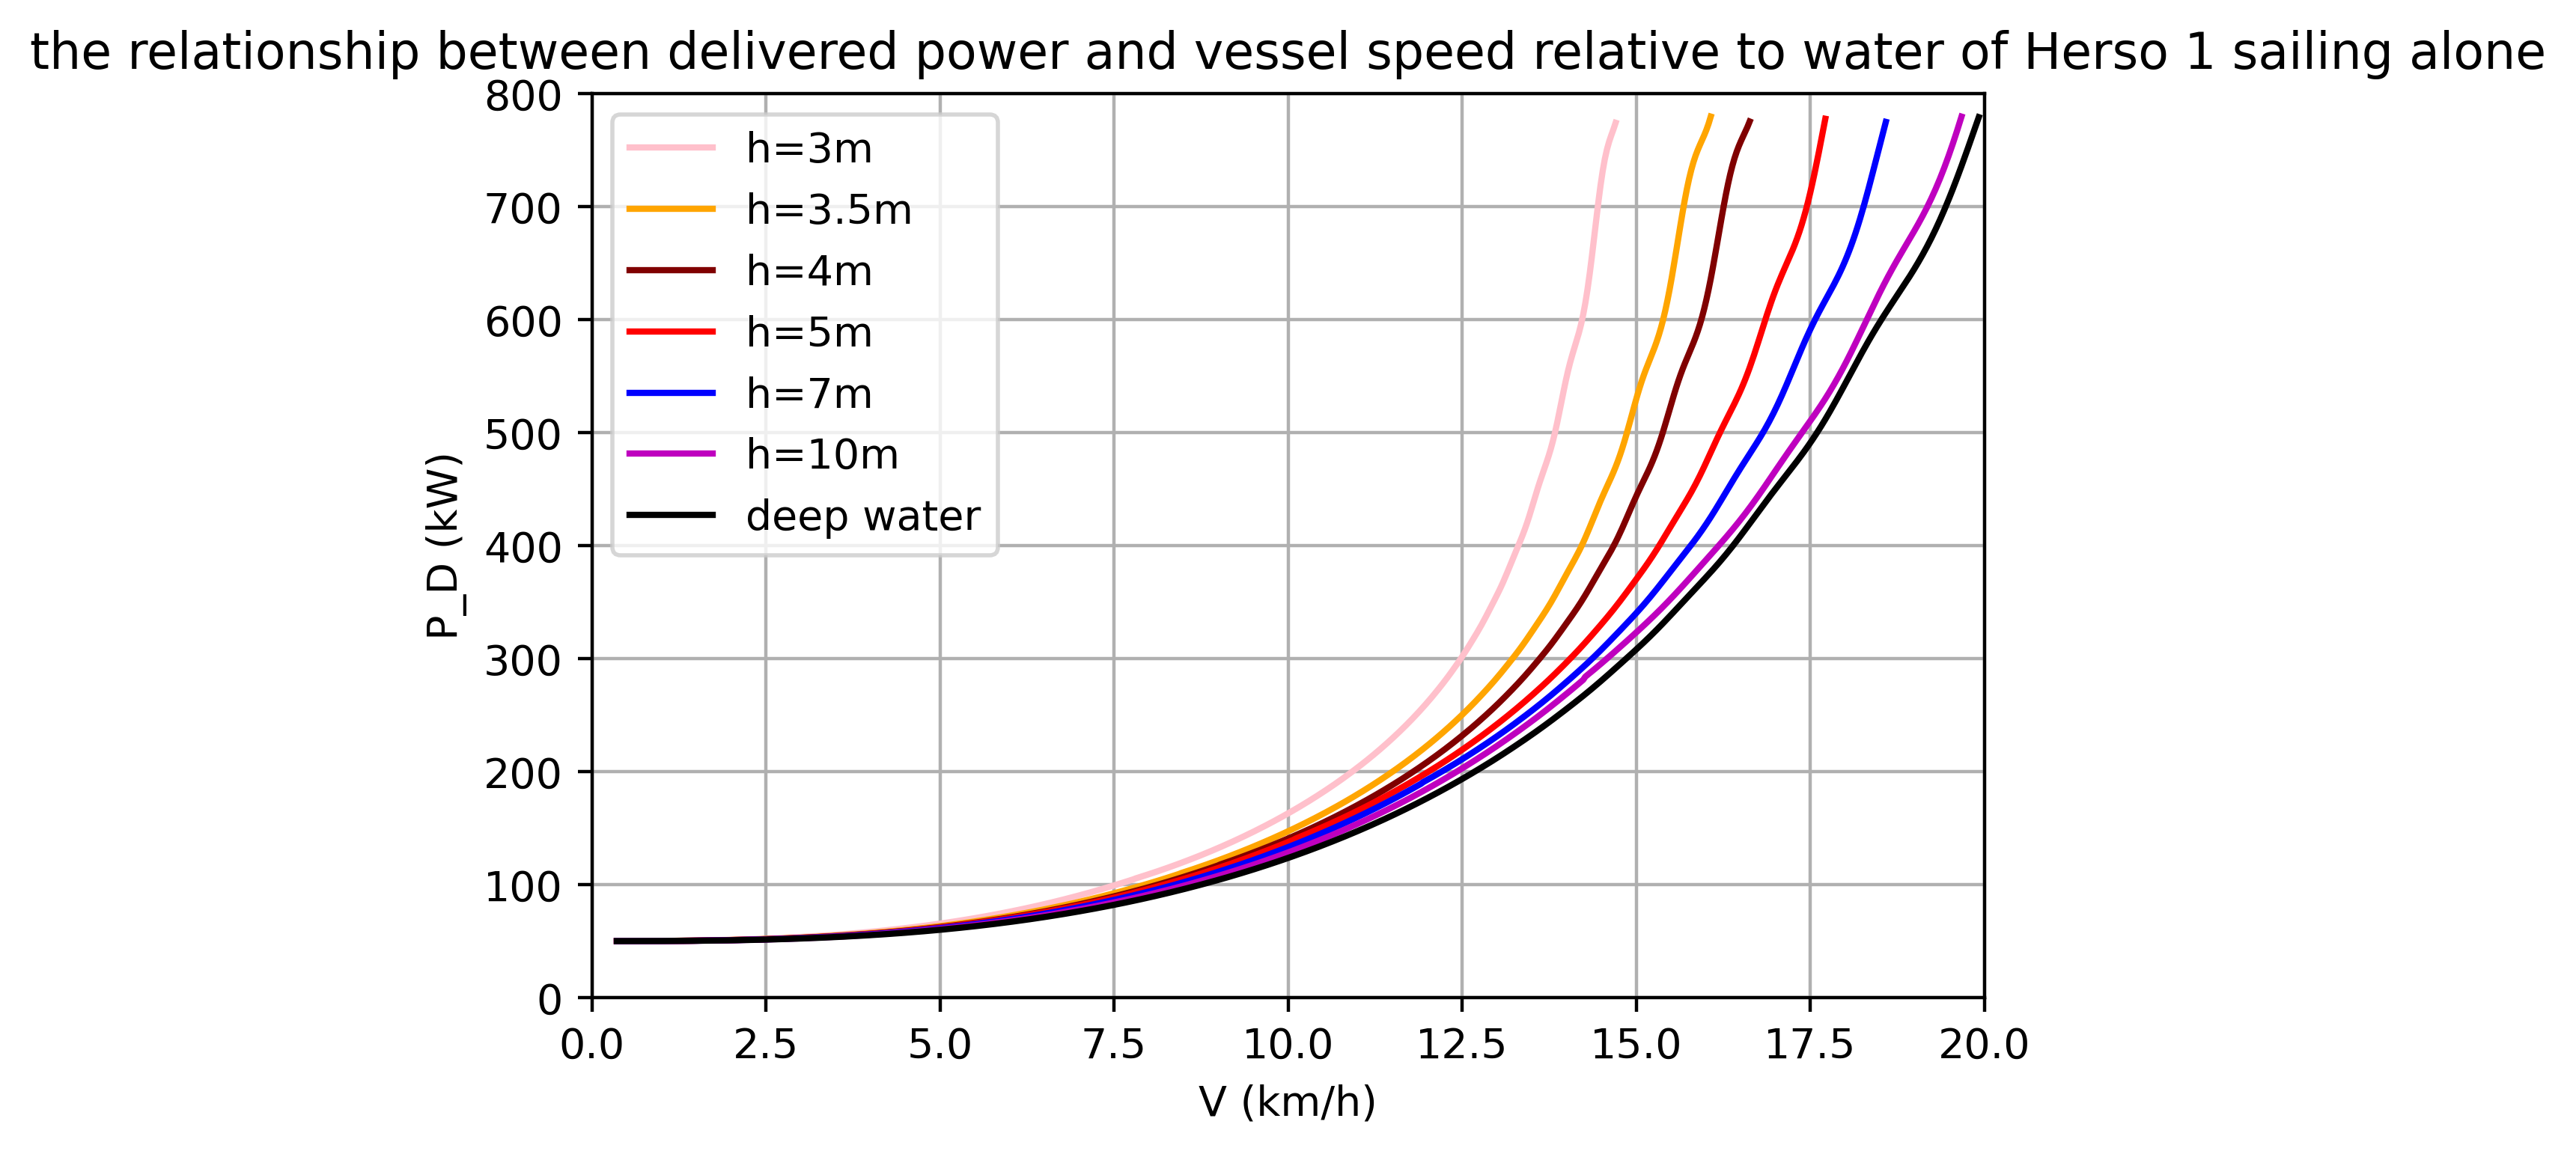

In [10]:
selected_h_3 = plot_df.query('h_0 == 3 & P_d < P_installed')
selected_h_3_5 = plot_df.query('h_0 == 3.5 & P_d < P_installed')
selected_h_4 = plot_df.query('h_0 == 4 & P_d < P_installed')
selected_h_5 = plot_df.query('h_0 == 5 & P_d < P_installed')
selected_h_6 = plot_df.query('h_0 == 6 & P_d < P_installed')
selected_h_7 = plot_df.query('h_0 == 7 & P_d < P_installed')
selected_h_8 = plot_df.query('h_0 == 8 & P_d < P_installed')
selected_h_9 = plot_df.query('h_0 == 9 & P_d < P_installed')
selected_h_10 = plot_df.query('h_0 == 10 & P_d < P_installed')
selected_h_deep = plot_df.query('h_0 == 20 & P_d < P_installed')
plt.figure(dpi=400)
plt.plot(selected_h_3['V_s_km'],selected_h_3['P_d'], 'pink', linewidth = 1.5)
plt.plot(selected_h_3_5['V_s_km'],selected_h_3_5['P_d'], 'orange', linewidth = 1.5)
plt.plot(selected_h_4['V_s_km'],selected_h_4['P_d'], 'maroon', linewidth = 1.5)
plt.plot(selected_h_5['V_s_km'],selected_h_5['P_d'], 'r', linewidth = 1.5)
# plt.plot(selected_h_6['V_s_km'],selected_h_6['P_d'], 'g', linewidth = 1)
plt.plot(selected_h_7['V_s_km'],selected_h_7['P_d'], 'b', linewidth = 1.5)
# plt.plot(selected_h_8['V_s_km'],selected_h_8['P_d'], 'r', linewidth = 1.0)
# plt.plot(selected_h_9['V_s_km'],selected_h_9['P_d'], 'g', linewidth = 1)
plt.plot(selected_h_10['V_s_km'],selected_h_10['P_d'], 'm', linewidth = 1.5)
plt.plot(selected_h_deep['V_s_km'],selected_h_deep['P_d'], 'k', linewidth = 1.5)

plt.xlabel('V (km/h)')
plt.ylabel('P_D (kW)')
plt.legend(['h=3m','h=3.5m','h=4m','h=5m','h=7m','h=10m','deep water'])
plt.grid()
plt.xlim(0, 20)
plt.ylim(0,800)
plt.title('the relationship between delivered power and vessel speed relative to water of Herso 1 sailing alone');